PROOJECT PhaseFoundry: A “foundry” for phase-field, CALPHAD, and ML interatomic potentials 
====================================

Description:
-------------
This notebook implements a thermodynamically consistent phase-field model for simulating spinodal decomposition and microstructural evolution in multicomponent alloy systems. The framework is coupled with pyCALPHAD to incorporate CALPHAD-based free energies directly from thermodynamic databases, enabling accurate thermodynamic representation. First-order derivatives of the free energy are computed using a semi-analytical approach to improve numerical precision. The thermodynamic descriptions are derived from databases constructed using machine learning–based interatomic potentials, allowing flexible and data-driven thermodynamic integration.

Features:
- Multicomponent Cahn–Hilliard equation using pseudo-spectral method
- Periodic boundary conditions
- Supports both idealized and CALPHAD-based free energy descriptions

Contributors:
-------------
- Vahid Attari, Arroyave Research Group, Texas A&M University
- Adapted from original MATLAB implementation (CH_EI.m)

Model Name:
------------
CALPHAD-Reinforced CH-PFM (Cahn–Hilliard Phase-Field Model)

Model Name:
------------
- Phase-field Models: Vahid Attari, Ph.D., TAMU (attari.v@tamu.edu)
  - Semi-implicit solver for Cahn-Hillaird Model coupled to semi-analytic derivatives of thermodynamic properties
- pyCALPHAD model: Courtney Kunselman, TAMU (cjkunselman18@tamu.edu)
  - semi-analytic derivatives of thermodynamic properties

License:
---------
MIT License (feel free to reuse and modify with attribution)

In [1]:
!pip install plotly
!pip install tqdm
!pip install umap-learn

In [2]:
import numpy as np
from numpy.fft import fftn, ifftn, fftfreq
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
from tqdm import tqdm
import os
print(os.getcwd())

/Users/attari.v/Documents/PROJECTS/pycalphad/phase-field-example


# Binary Solver
- Using polynomial energy model

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 1980/2000 [00:04<00:00, 495.49it/s]

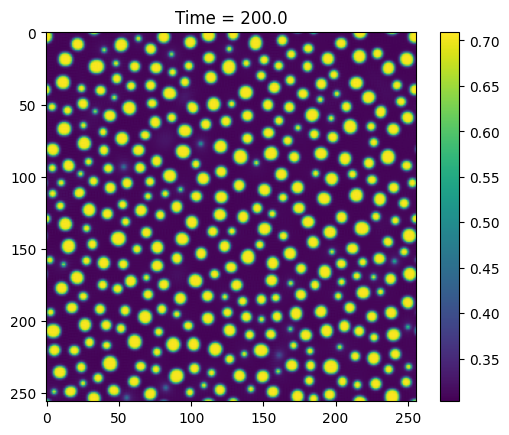

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 468.60it/s]


In [3]:
# ==== Material Parameters ====
X11 = 0.4        # Initial composition
Kappa_c = 0.1    # Gradient energy coefficient
M = 1.0          # Mobility
rho_s = 5.0      # Free energy prefactor

# ==== Grid Setup ====
Lx = 200
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# MATLAB-style frequency vector: [0:N/2-1 0 -N/2+1:-1]
k = np.concatenate((
    np.arange(0, N//2),   # 0 to 127
    [0],                  # Center value (same as in MATLAB)
    np.arange(-N//2+1, 0) # -127 to -1
))

# ==== Fourier Space Setup ====
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Condition ====
np.random.seed(0)
c = X11 + 0.01 * (np.random.rand(N, N) - 0.5)

# ==== Time Setup ====
dt = 0.1
tmax = 200
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Create Output Folder ====
if os.path.exists("microstructure-binary"):
    os.system("rm -r microstructure-binary")
os.makedirs("microstructure-binary", exist_ok=True)

# ==== Free Energy Derivative ====
def dFdc(c, rho_s):
    c_a = 0.3;
    c_b = 0.7;    
    return -2 * rho_s * (c-c_a) * (c-c_b) * (c_a+c_b-2*c)  # Double-well derivative

# ==== Data Storage ====
field, time_arr, Y1, Y2, Y3, Y4 = [], [], [], [], [], []

# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    mu = dFdc(c, rho_s)
    mu_hat = fft2(mu)
    c_hat = fft2(c)
    num = c_hat + M * dt * k2 * mu_hat
    denom = 1 + 2 * M * Kappa_c * dt * k2**2
    c = np.real(ifft2(num / denom))

    if n == 1 or n in plot_indices or n == max_iter:
        field.append(c.copy())
        time_arr.append(n * dt)
        Y1.append(np.mean(c > X11))                       # Crude vol. frac
        Y2.append(np.mean(np.abs(np.gradient(c)[0])))     # Crude length scale
        Y3.append(np.max(c))                              # Max composition
        Y4.append(np.min(c))                              # Min composition

        plt.imshow(c, cmap='viridis')
        plt.title(f'Time = {n*dt:.1f}')
        plt.colorbar()
        plt.savefig(f'microstructure-binary/comp_time_frame{n}.jpg')
        if n == max_iter:
            plt.show()        
        plt.close()        

# ==== Save Simulation Data ====
np.savez("sim_result.npz",
         init_conditions={'X11': X11, 'Lx': Lx, 'Ly': Lx, 'mesh_size': N, 'dx': h, 'dt': dt},
         evolution={'field_order_parameter': field, 'time': time_arr},
         metrics={'vol_frac': Y1, 'char_length_scale': Y2, 'max_comp': Y3, 'min_comp': Y4})

# Ternary Solver
## Polynomial Model

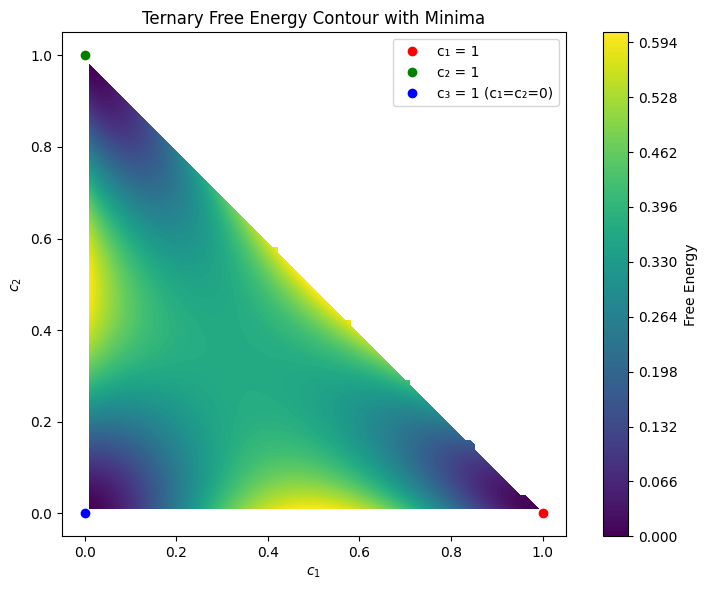

In [4]:
import numpy as np
import matplotlib.pyplot as plt
    
# Free energy function
def fchem_three_well(c1, c2, rho_s=10):
    c3 = 1.0 - c1 - c2
    return rho_s * (c1**2 * c2**2 + c2**2 * c3**2 + c3**2 * c1**2)

# Composition grid
delta = 0.01
c1_vals = np.arange(0.01, 0.99 + delta, delta)
c2_vals = np.arange(0.01, 0.99 + delta, delta)
X, Y = np.meshgrid(c1_vals, c2_vals)
Z = 1.0 - X - Y

# Mask valid region (c3 > 0)
F = np.full_like(X, np.nan)
mask = Z > 0
F[mask] = fchem_three_well(X[mask], Y[mask])

# Plot contour
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, F, levels=100, cmap='viridis')
plt.colorbar(contour, label='Free Energy')

# Mark ideal minima: (1,0,0), (0,1,0), (0,0,1)
ax.plot(1, 0, 'ro', label='c₁ = 1')
ax.plot(0, 1, 'go', label='c₂ = 1')
ax.plot(0, 0, 'bo', label='c₃ = 1 (c₁=c₂=0)')

# Format
ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')
ax.set_title('Ternary Free Energy Contour with Minima')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('energy_landscape_ternary.jpg',dpi=300)
plt.show()

 99%|████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1978/2000 [00:10<00:00, 224.50it/s]

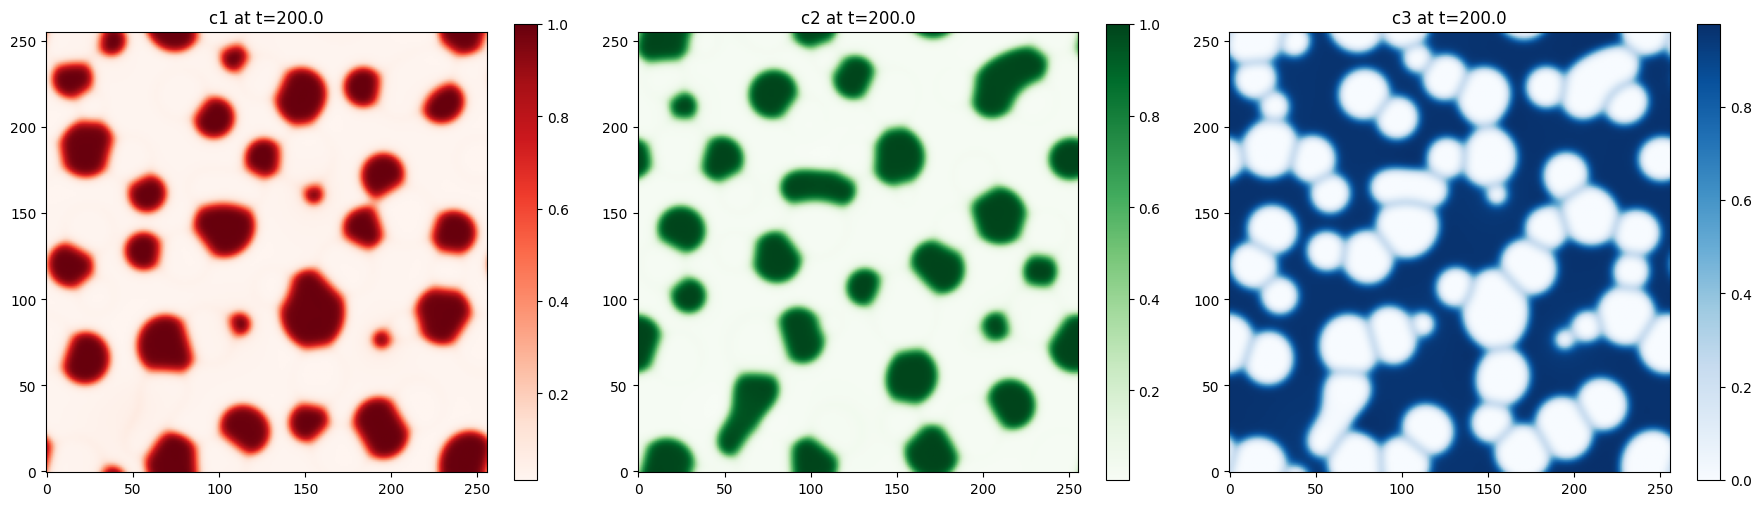

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 186.44it/s]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2
import os
from tqdm import tqdm

# ==== Simulation Parameters ====
Kappa_c = 20.0    # Gradient energy coefficient
M = 1.0          # Mobility
rho_s = 20.0     # Free energy prefactor

# ==== Grid Setup ====
Lx = 200
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# ==== Spectral k-vectors ====
k = np.concatenate((np.arange(0, N//2), [0], np.arange(-N//2+1, 0)))
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Conditions ====
np.random.seed(0)
c1 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c2 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c3 = 1.0 - c1 - c2

# ==== Time Setup ====
dt = 0.1
tmax = 200
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Output Directory ====
if os.path.exists("microstructure-ternary"):
    os.system("rm -r microstructure-ternary")
os.makedirs("microstructure-ternary", exist_ok=True)

# ==== Free Energy Function ====
def fchem_three_well(c1, c2, rho_s=20):
    c3 = 1.0 - c1 - c2
    return rho_s * (c1**2 * c2**2 + c2**2 * c3**2 + c3**2 * c1**2)

# ==== Chemical Potential Derivatives ====
def dfdc1(c1, c2, rho_s):
    c3 = 1.0 - c1 - c2
    return rho_s * (2*c1*c2**2 + 2*c1*c3**2 - 2*c1**2*c3)

def dfdc2(c1, c2, rho_s):
    c3 = 1.0 - c1 - c2
    return rho_s * (2*c2*c1**2 + 2*c2*c3**2 - 2*c2**2*c3)

# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    mu1 = dfdc1(c1, c2, rho_s)
    mu2 = dfdc2(c1, c2, rho_s)

    mu1_hat = fft2(mu1)
    mu2_hat = fft2(mu2)
    c1_hat = fft2(c1)
    c2_hat = fft2(c2)

    num1 = c1_hat + M * dt * k2 * mu1_hat
    num2 = c2_hat + M * dt * k2 * mu2_hat
    denom = 1 + 2 * M * Kappa_c * dt * k2**2

    c1 = np.real(ifft2(num1 / denom))
    c2 = np.real(ifft2(num2 / denom))
    c3 = 1.0 - c1 - c2

    # Clip to physical range
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    c3 = np.clip(c3, 0.0, 1.0)

    # Plot results
    if n == 1 or n in plot_indices or n == max_iter:
        plt.figure(figsize=(18, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(c1, cmap='Reds', origin='lower')
        plt.title(f'c1 at t={n*dt:.1f}')
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.imshow(c2, cmap='Greens', origin='lower')
        plt.title(f'c2 at t={n*dt:.1f}')
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.imshow(c3, cmap='Blues', origin='lower')
        plt.title(f'c3 at t={n*dt:.1f}')
        plt.colorbar()

        plt.tight_layout()
        plt.savefig(f'microstructure-ternary/ternary_frame_{n}.jpg')
        if n == max_iter:
            plt.show()
        plt.close()

# Quaternary

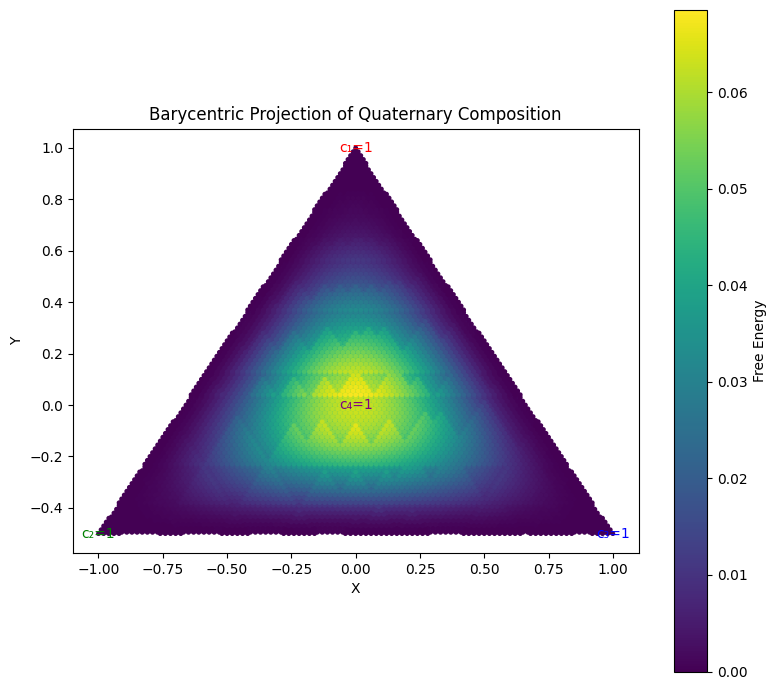

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Free energy model 1
def fchem_quaternary(c1, c2, c3, c4, rho_s=20):
    return rho_s * (
        c1**2 * c2**2 + c1**2 * c3**2 + c1**2 * c4**2 +
        c2**2 * c3**2 + c2**2 * c4**2 + c3**2 * c4**2
    )
    
# Free energy model 2
def fchem_four_well(c1, c2, c3, c4, rho_s=50):
    f1 = (c1 - 1)**2 * c2**2 * c3**2 * c4**2
    f2 = (c2 - 1)**2 * c1**2 * c3**2 * c4**2
    f3 = (c3 - 1)**2 * c1**2 * c2**2 * c4**2
    f4 = (c4 - 1)**2 * c1**2 * c2**2 * c3**2
    return rho_s * (f1 + f2 + f3 + f4)

# Generate valid quaternary compositions
delta = 0.01
comps = []
for c1 in np.arange(0, 1+delta, delta):
    for c2 in np.arange(0, 1-c1+delta, delta):
        for c3 in np.arange(0, 1-c1-c2+delta, delta):
            c4 = 1.0 - c1 - c2 - c3
            if 0 <= c4 <= 1:
                comps.append([c1, c2, c3, c4])
comps = np.array(comps)
c1, c2, c3, c4 = comps[:,0], comps[:,1], comps[:,2], comps[:,3]

# Compute free energy
fchem_four_well
#F = fchem_quaternary(c1, c2, c3, c4)
F = fchem_four_well(c1, c2, c3, c4)

# Define 4 2D corners for a diamond-shaped quad
v1 = np.array([0.0, 1.0])   # c1 = 1 (top)
v2 = np.array([-1.0, -0.5]) # c2 = 1 (bottom-left)
v3 = np.array([1.0, -0.5])  # c3 = 1 (bottom-right)
v4 = np.array([0.0, 0.0])   # c4 = 1 (center-bottom)

# Project to 2D using barycentric blend of vertices
XY = (np.outer(c1, v1) +
      np.outer(c2, v2) +
      np.outer(c3, v3) +
      np.outer(c4, v4))
X, Y = XY[:,0], XY[:,1]

# Plot
fig, ax = plt.subplots(figsize=(8, 7))
sc = ax.scatter(X, Y, c=F, cmap='viridis', s=12, edgecolors='none')
plt.colorbar(sc, label="Free Energy")

# Label corners
ax.text(*v1, "c₁=1", color='red', ha='center', va='center')
ax.text(*v2, "c₂=1", color='green', ha='center', va='center')
ax.text(*v3, "c₃=1", color='blue', ha='center', va='center')
ax.text(*v4, "c₄=1", color='purple', ha='center', va='center')

ax.set_title("Barycentric Projection of Quaternary Composition")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████▋| 3988/4000 [00:25<00:00, 200.56it/s]

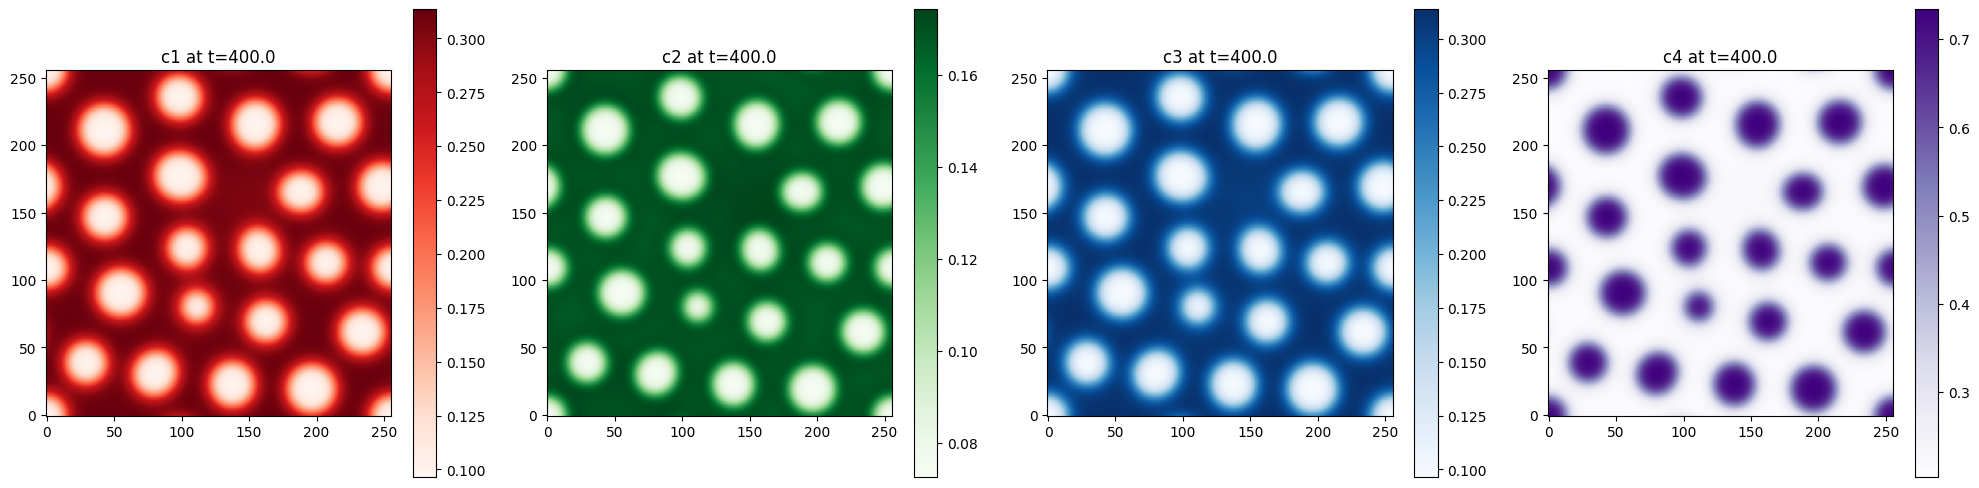

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:25<00:00, 154.61it/s]


In [7]:
# ==== Simulation Parameters ====
Kappa_c = 20.0
M = 1.0
rho_s = 20.0

# ==== Grid Setup ====
Lx = 200
N = 256
h = Lx / (N - 1)
x = np.linspace(0, Lx, N)
y = x.copy()
xx, yy = np.meshgrid(x, y)

# ==== Spectral k-vectors ====
k = np.concatenate((np.arange(0, N//2), [0], np.arange(-N//2+1, 0)))
g = 2 * np.pi / Lx
kx = g * 1j * k
ky = g * 1j * k
kx, ky = np.meshgrid(kx, ky)
k2 = kx**2 + ky**2

# ==== Initial Conditions ====
np.random.seed(0)
c1 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c2 = 0.15 + 0.01 * (np.random.rand(N, N) - 0.5)
c3 = 0.25 + 0.01 * (np.random.rand(N, N) - 0.5)
c4 = 1.0 - c1 - c2 - c3

# ==== Time Setup ====
dt = 0.1
tmax = 400
max_iter = int(tmax / dt)
plot_indices = np.linspace(0, max_iter, 20, dtype=int)

# ==== Output Directory ====
if os.path.exists("microstructure-quaternary"):
    os.system("rm -r microstructure-quaternary")
os.makedirs("microstructure-quaternary", exist_ok=True)

# ==== Free Energy Function ====
def fchem_quaternary(c1, c2, c3, c4, rho_s=20):
    return rho_s * (
        c1**2 * c2**2 + c1**2 * c3**2 + c1**2 * c4**2 +
        c2**2 * c3**2 + c2**2 * c4**2 + c3**2 * c4**2
    )

def fchem_four_well(c1, c2, c3, c4, rho_s=20):
    f1 = (c1 - 1)**2 * c2**2 * c3**2 * c4**2
    f2 = (c2 - 1)**2 * c1**2 * c3**2 * c4**2
    f3 = (c3 - 1)**2 * c1**2 * c2**2 * c4**2
    f4 = (c4 - 1)**2 * c1**2 * c2**2 * c3**2
    return rho_s * (f1 + f2 + f3 + f4)
    

# ==== Chemical Potential Derivatives ====
def dfdc1(c1, c2, c3, c4, rho_s):
    return rho_s * (2 * c1 * c2**2 + 2 * c1 * c3**2 + 2 * c1 * c4**2)

def dfdc2(c1, c2, c3, c4, rho_s):
    return rho_s * (2 * c2 * c1**2 + 2 * c2 * c3**2 + 2 * c2 * c4**2)

def dfdc3(c1, c2, c3, c4, rho_s):
    return rho_s * (2 * c3 * c1**2 + 2 * c3 * c2**2 + 2 * c3 * c4**2)

# ==== Simulation Loop ====
for n in tqdm(range(1, max_iter + 1)):
    c4 = 1.0 - c1 - c2 - c3

    mu1 = dfdc1(c1, c2, c3, c4, rho_s)
    mu2 = dfdc2(c1, c2, c3, c4, rho_s)
    mu3 = dfdc3(c1, c2, c3, c4, rho_s)

    mu1_hat = fft2(mu1)
    mu2_hat = fft2(mu2)
    mu3_hat = fft2(mu3)

    c1_hat = fft2(c1)
    c2_hat = fft2(c2)
    c3_hat = fft2(c3)

    denom = 1 + 2 * M * Kappa_c * dt * k2**2

    c1 = np.real(ifft2((c1_hat + M * dt * k2 * mu1_hat) / denom))
    c2 = np.real(ifft2((c2_hat + M * dt * k2 * mu2_hat) / denom))
    c3 = np.real(ifft2((c3_hat + M * dt * k2 * mu3_hat) / denom))
    c4 = 1.0 - c1 - c2 - c3

    # Clip to physical range
    c1 = np.clip(c1, 0.0, 1.0)
    c2 = np.clip(c2, 0.0, 1.0)
    c3 = np.clip(c3, 0.0, 1.0)
    c4 = np.clip(c4, 0.0, 1.0)

    if n == 1 or n in plot_indices or n == max_iter:
        plt.figure(figsize=(20, 5))
        for idx, (c, label, cmap) in enumerate(zip([c1, c2, c3, c4], ['c1', 'c2', 'c3', 'c4'], ['Reds', 'Greens', 'Blues', 'Purples'])):
            plt.subplot(1, 4, idx+1)
            plt.imshow(c, cmap=cmap, origin='lower')
            plt.title(f'{label} at t={n*dt:.1f}')
            plt.colorbar()
        plt.tight_layout()
        plt.savefig(f'microstructure-quaternary/quaternary_frame_{n}.jpg')
        if n == max_iter:
            plt.show()
        plt.close()

# Coupling Phase-field with PyCalphad

In [2]:
import pycalphad
print(pycalphad.__version__)

from pycalphad import Workspace, Database, variables as v
from pycalphad.property_framework import IsolatedPhase

0.1.dev1968+g9b64c32


In [30]:
# To calculate Jansson derivatives, we first establish a Workspace with the specified conditions and then use "get" to run the equilibrium and 
# derivative calculation
# Here, I have specified the same composition at various temperatures, so the output of any "get" will be a vector
wks = Workspace(database=Database('HF_NB_TI_V.TDB'), components=['HF', 'NB', 'TI', 'V'], phases=['BCC_A2'],
                 conditions={v.X('HF'): 0.25, v.X('NB'): 0.25, v.X('TI'): 0.25, v.T: (300,3000,50), v.P: 101325})

# We need to make sure that we use IsolatedPhase so that the minimizer does not give us a solution with phase separation, but rather stays on the 
# free energy surface. First derivatives of the free energy wrt composition can be calculated with a Jansson derivative or by the relationship
# dG/dx_A = mu_A - mu_B where B is the dependent component
ip = IsolatedPhase('BCC_A2', wks=wks)
dG_dx_HF_option1 = wks.get(ip('GM.X(HF)'))
dG_dx_NB_option1 = wks.get(ip('GM.X(NB)'))
dG_dx_TI_option1 = wks.get(ip('GM.X(TI)'))
#dG_dx_V_option1 = wks.get(ip('GM.X(V)'))
dG_dx_HF_option2 = wks.get(ip('MU(HF)')) - wks.get(ip('MU(V)'))

# derivatives of chemical potential are found similarly
dmuHF_dx_HF = wks.get(ip('MU(HF).X(HF)'))

print(dG_dx_HF_option1)
print(dG_dx_HF_option2)

[  5031.13719228   3911.55380742   2805.57522958   1711.2608954
    626.92234289   -448.7547117   -1516.75539071  -2577.80916779
  -3632.45559535  -4681.09565915  -5724.02969594  -6761.45452178
  -7793.39603626  -8819.77380132  -9840.43502963 -10855.17221272
 -11863.73674356 -12865.84939038 -13861.20873797 -14849.49778728
 -15830.38936128 -16803.55049263 -17768.6460407  -18725.34169694
 -19673.30650315 -20612.2149746  -21541.74890719 -22461.59892038
 -23371.46578757 -24271.06158448 -25160.11069005 -26038.35066014
 -26905.53299579 -27761.42383159 -28605.80447339 -29438.47205759
 -30259.23988894 -31067.93795197 -31864.41713857 -32648.70925859
 -33421.18682209 -34182.3612386  -34932.83631604 -35673.28631785
 -36404.44000146 -37127.05910043 -37841.97059025 -38549.98915879
 -39251.92226735 -39948.53092518 -40640.5054198  -41328.44540339
 -42012.84364667 -42694.07283649]
[  5031.13719228   3911.55380742   2805.57522958   1711.2608954
    626.92234289   -448.7547117   -1516.75539071  -2577.80

# Compute chemical potentials as a function of Composition

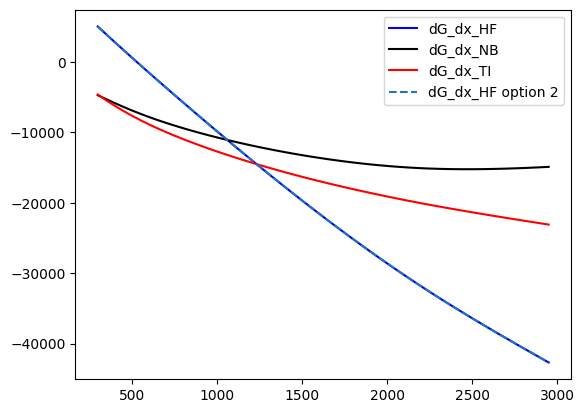

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(0)
plt.plot(np.arange(300,3000,50), dG_dx_HF_option1, c='blue', label='dG_dx_HF')
plt.plot(np.arange(300,3000,50), dG_dx_NB_option1, c='black', label='dG_dx_NB')
plt.plot(np.arange(300,3000,50), dG_dx_TI_option1, c='red', label='dG_dx_TI')
plt.plot(np.arange(300,3000,50), dG_dx_HF_option2, linestyle = 'dashed', label='dG_dx_HF option 2')
plt.legend()

## Compute Gibbs Free Energy of as a function of Nb Composition for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$

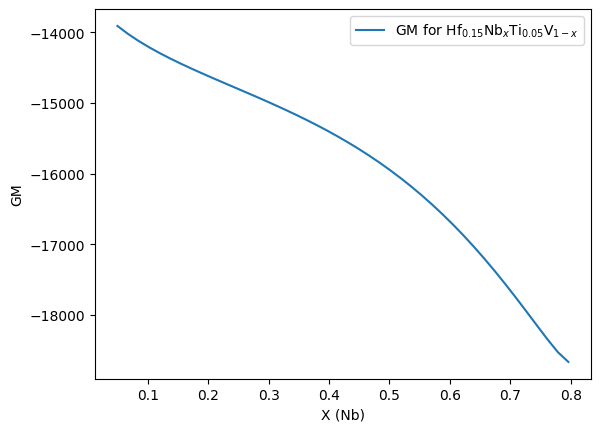

In [34]:
x_nb = np.linspace(0.05, 0.90, 50)
G = []
for x in x_nb:
    wks = Workspace(database=Database('HF_NB_TI_V.TDB'), components=['HF', 'NB', 'TI', 'V'], phases=['BCC_A2'],
            conditions={v.X('HF'): 0.15, v.X('NB'): x, v.X('TI'): 0.05, v.T: 500, v.P: 101325})
    ip = IsolatedPhase('BCC_A2', wks=wks)
    G.append(wks.get(ip('GM')))
plt. plot(x_nb,G, label=r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$")
plt.xlabel('X (Nb)')
plt.ylabel('GM')
#plt.title(r"GM for Hf$_{0.15}$Nb$_{x}$Ti$_{0.05}$V$_{1-x}$");
plt.legend()

['HF', 'NB', 'TI', 'V']
{X_HF: 0.25, X_NB: 0.25, X_TI: 0.25, T: (300, 3000, 50), P: 101325}
dG/dx_HF = [  6243.14884847   5246.68237016   4249.87670481   3251.29310112
   2247.92017857   1353.67283073    214.45494667             nan
  -2044.16941995  -3173.14459533  -4313.64335797  -5465.50198565
  -6593.86076208  -7706.76572471  -8809.81686569  -9904.73283351
 -10992.83551948 -12865.84939038             nan -14224.57569581
 -15292.51470473 -16803.55049263 -17415.49719275 -18470.52910894
 -19521.13915969 -20567.18421792 -21541.74890704 -22461.59892038
 -23371.46578757 -24271.06158446 -25160.11068994 -26038.35066009
 -26905.53299577 -27761.42381939 -28605.80447415 -29438.47205658
 -30259.23989141 -31067.93795652 -31864.4171392  -32648.70925865
 -33421.18681924 -34182.36123881 -34932.83631641 -35673.28631725
 -36404.44000073 -37127.05910113 -37841.97058981 -38549.98915967
 -39251.92226795 -39948.53092541 -40640.505419   -41328.44540328
 -42012.84364584 -42694.07283644]
dG/dx_NB = [ -1591

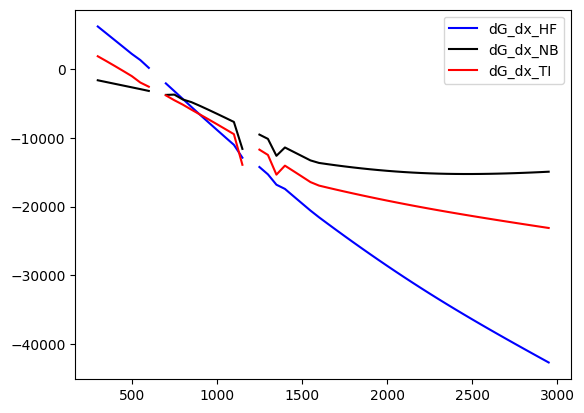

In [35]:
from pycalphad import Database, variables as v
from pycalphad.core.workspace import Workspace

def compute_dGdx_from_mu(db_path, phase, composition_dict, T_range, P=101325, reference_component='V'):
    """
    Computes dG/dx_i using μ_i - μ_ref for fixed compositions in a quaternary system.

    Parameters:
    -----------
    db_path : str
        Path to the TDB file.
    phase : str
        Phase name (e.g., 'BCC_A2').
    composition_dict : dict
        Dict with 3 components fixed (e.g., {'HF': 0.25, 'NB': 0.25, 'TI': 0.25}).
    T_range : tuple
        (T_min, T_max, T_step)
    P : float
        Pressure
    reference_component : str
        The dependent component to use as reference (e.g., 'V')

    Returns:
    --------
    dict
        Dictionary with μ_i - μ_ref values (dG/dx_i equivalents).
    """
    components = list(composition_dict.keys()) + [reference_component]
    conditions = {v.X(k): composition_dict[k] for k in composition_dict}
    T_min, T_max, T_step = T_range
    conditions.update({v.T: (T_min, T_max, T_step), v.P: P})

    print(components)
    print(conditions)

    db = Database(db_path)
    wks = Workspace(database=db, components=components, phases=[phase], conditions=conditions)

    mu_ref = wks.get(f"MU({reference_component})")
    derivs = {}

    for comp in composition_dict.keys():
        mu_i = wks.get(f"MU({comp})")
        derivs[comp] = mu_i - mu_ref  # This is dG/dx_i

    return derivs

# Compute example chemical potentials

composition = {'HF': 0.25, 'NB': 0.25, 'TI': 0.25}
T_range = (300, 3000, 50)

dGdx = compute_dGdx_from_mu(
    db_path='HF_NB_TI_V.TDB',
    phase='BCC_A2',
    composition_dict=composition,
    T_range=T_range
)

print("dG/dx_HF =", dGdx['HF'])
print("dG/dx_NB =", dGdx['NB'])
print("dG/dx_TI =", dGdx['TI'])

plt.figure(0)
plt.plot(np.arange(300,3000,50), dGdx['HF'], c='blue', label='dG_dx_HF')
plt.plot(np.arange(300,3000,50), dGdx['NB'], c='black', label='dG_dx_NB')
plt.plot(np.arange(300,3000,50), dGdx['TI'], c='red', label='dG_dx_TI')
#plt.plot(np.arange(300,3000,50), dG_dx_V_option1, c='orange', label='dG_dx_HF')
#plt.plot(np.arange(300,3000,50), dG_dx_HF_option2, linestyle = 'dashed', label='dG_dx_HF option 2')
plt.legend()

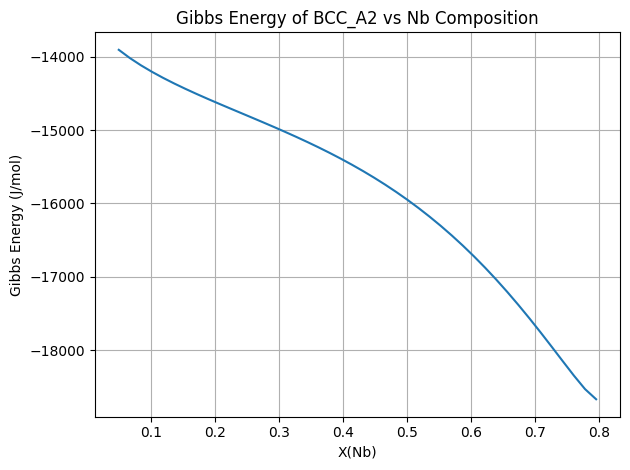

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v
#from pycalphad.workspace.solution_managers import IsolatedPhase

# Sweep over Nb composition
x_nb = np.linspace(0.05, 0.90, 50)
G = []

for x in x_nb:
    wks = Workspace(
        database=Database('HF_NB_TI_V.TDB'),
        components=['HF', 'NB', 'TI', 'V'],
        phases=['BCC_A2'],
        conditions={
            v.X('HF'): 0.15,
            v.X('NB'): x,
            v.X('TI'): 0.05,
            v.T: 500,
            v.P: 101325
        }
    )
    ip = IsolatedPhase('BCC_A2', wks=wks)
    G.append(wks.get(ip('GM')).squeeze())  # Remove singleton dims

# Plotting
plt.plot(x_nb, G)
plt.xlabel('X(Nb)')
plt.ylabel('Gibbs Energy (J/mol)')
plt.title('Gibbs Energy of BCC_A2 vs Nb Composition')
plt.grid(True)
plt.tight_layout()
plt.show()

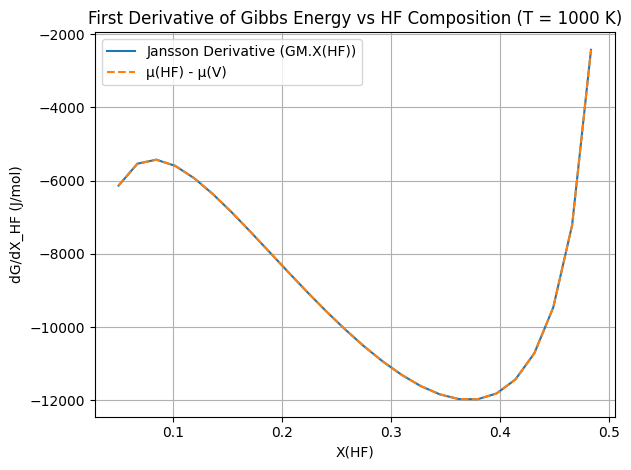

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v#, IsolatedPhase

# Sweep over HF composition (0.05 to 0.90)
x_hf = np.linspace(0.05, 0.90, 50)

# Lists to store derivatives
dG_dx_HF_opt1 = []
dG_dx_HF_opt2 = []

# Loop over composition values
for x in x_hf:
    wks = Workspace(
        database=Database('HF_NB_TI_V.TDB'),
        components=['HF', 'NB', 'TI', 'V'],
        phases=['BCC_A2'],
        conditions={
            v.X('HF'): x,
            v.X('NB'): 0.25,
            v.X('TI'): 0.25,
            v.T: 1000,       # fixed temperature
            v.P: 101325
        }
    )
    ip = IsolatedPhase('BCC_A2', wks=wks)
    d1 = wks.get(ip('GM.X(HF)')).squeeze()
    d2 = (wks.get(ip('MU(HF)')) - wks.get(ip('MU(V)'))).squeeze()
    
    dG_dx_HF_opt1.append(d1)
    dG_dx_HF_opt2.append(d2)

# Plot
plt.figure()
plt.plot(x_hf, dG_dx_HF_opt1, label='Jansson Derivative (GM.X(HF))')
plt.plot(x_hf, dG_dx_HF_opt2, '--', label='μ(HF) - μ(V)')
plt.xlabel('X(HF)')
plt.ylabel('dG/dX_HF (J/mol)')
plt.title('First Derivative of Gibbs Energy vs HF Composition (T = 1000 K)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

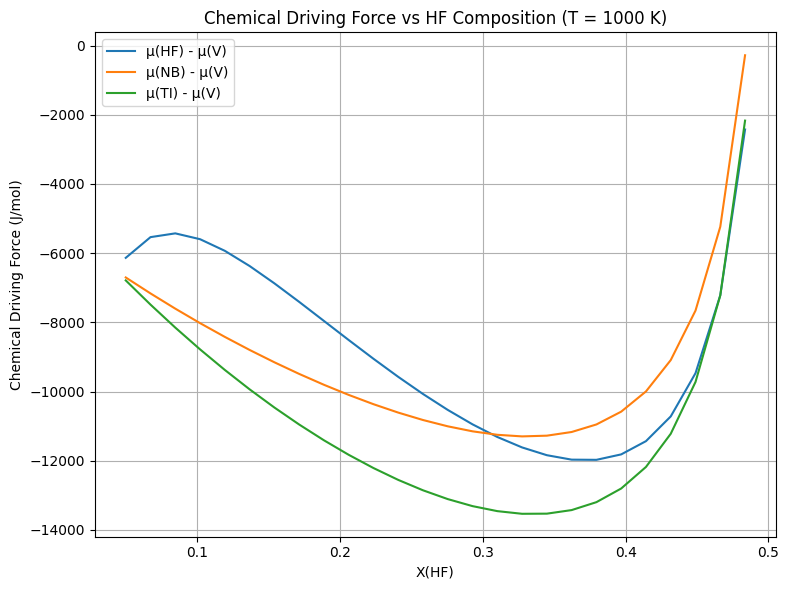

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from pycalphad import Workspace, Database, variables as v

# Sweep over HF composition
x_hf = np.linspace(0.05, 0.90, 50)

# Initialize dict to hold chemical driving forces for all elements
driving_forces = {el: [] for el in ['HF', 'NB', 'TI', 'V']}

# Loop over compositions
for x in x_hf:
    wks = Workspace(
        database=Database('HF_NB_TI_V.TDB'),
        components=['HF', 'NB', 'TI', 'V'],
        phases=['BCC_A2'],
        conditions={
            v.X('HF'): x,
            v.X('NB'): 0.25,
            v.X('TI'): 0.25,
            v.T: 1000,
            v.P: 101325
        }
    )
    ip = IsolatedPhase('BCC_A2', wks=wks)

    # Reference chemical potential (e.g., V)
    mu_ref = wks.get(ip('MU(V)')).squeeze()

    # Driving force: mu_i - mu_ref
    for el in driving_forces:
        mu_i = wks.get(ip(f'MU({el})')).squeeze()
        driving_forces[el].append(mu_i - mu_ref)

# Plotting
plt.figure(figsize=(8, 6))
for el, values in driving_forces.items():
    if el != 'V':  # V will have zero driving force (mu_i - mu_i = 0)
        plt.plot(x_hf, values, label=f'μ({el}) - μ(V)')

plt.xlabel('X(HF)')
plt.ylabel('Chemical Driving Force (J/mol)')
plt.title('Chemical Driving Force vs HF Composition (T = 1000 K)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()